In [113]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, SplineTransformer
from sklearn.compose import ColumnTransformer
import os

In [36]:
df = pd.read_csv('Cleaned_Data.csv')

In [ ]:
artist_summary = df.groupby('artist')['score'].filter(
    lambda x: len(x) > 5
).groupby(df['artist']).agg(['mean', 'median']).sort_values(
    by='mean', ascending=False
).head(5)
print(artist_summary)

genre_summary = df.groupby('main_genre')['score'].filter(
    lambda x: len(x) > 45
    
).groupby(df['main_genre']).agg(['mean', 'median']).sort_values(
    by='mean', ascending=False
).head(5)
print(genre_summary)

                       mean  median
artist                             
Stevie Wonder      9.000000    9.45
Talking Heads      8.983333    8.70
Alice Coltrane     8.950000    8.65
Prince             8.710000    8.60
Bruce Springsteen  8.570000    8.65
                  mean  median
main_genre                    
Jazz          7.758576     7.7
Global        7.600000     7.6
Experimental  7.545765     7.6
Metal         7.480788     7.6
Folk/Country  7.477056     7.5


In [26]:
df1 = df.dropna()
y = df1['score']
X = df1[['review_release_difference','length', 'followers_count', 'reviewer_reviews']]#, , 'artist_review_number', 'genre', 'label']]
cats = []#['label', 'genre', 'artist_review_number']
nums = ['length', 'review_release_difference']

In [27]:
top_20_genres = df1['genre'].value_counts().head(20).index.tolist()
condition_genre = df1['genre'].isin(top_20_genres)
condition_difference = df1['review_release_difference'] < 2
df_filtered = df1[condition_genre & condition_difference].copy()

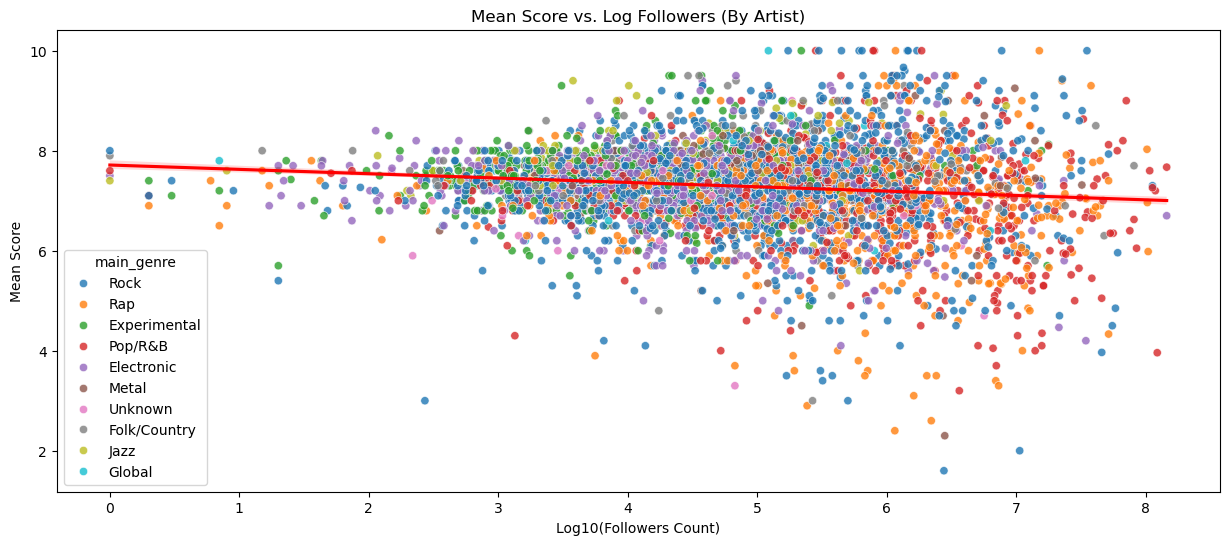

In [140]:
artist_df = df1.groupby('artist')[['followers_count', 'score', 'main_genre']].agg({
    'followers_count': 'mean',
    'score': 'mean',
    'main_genre': 'first'
}).reset_index()
artist_df['followers_count'] = artist_df['followers_count'].replace(0, 1)
artist_df['log_followers'] = np.log10(artist_df['followers_count'])

plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=artist_df, 
    x='log_followers', 
    y='score', 
    hue='main_genre',
    palette='tab10',
    alpha=0.8
)
sns.regplot(
    data=artist_df, 
    x="log_followers", 
    y="score", 
    scatter=False, 
    color="red"
)

plt.title("Mean Score vs. Log Followers (By Artist)")
plt.xlabel("Log10(Followers Count)")
plt.ylabel("Mean Score")

if not os.path.exists("Visualizations/pitchfork_followers_by_artist.png"):
    plt.savefig("Visualizations/pitchfork_followers_by_artist.png")

plt.show()

In [ ]:
df.groupby('genre').filter(lambda x: len(x) > 10).groupby('genre').agg(
    album_count=('score', 'size'),  # New column: Count of non-NaN scores in the group
    median_score=('score', 'mean'),
    mean_followers=('followers_count', 'mean'),
    mean_review_diff=('review_release_difference', 'mean')
).sort_values('median_score', ascending=False).head()

,album_count,median_score,mean_followers,mean_review_diff
genre,,,,
Jazz / Experimental,34,7.908824,7.611429e+04,5.676471
Experimental / Jazz,18,7.822222,4.970589e+04,4.687500
Jazz,241,7.766390,2.731634e+05,2.987179
Global,20,7.765000,7.576675e+05,8.315789
Folk/Country / Pop/R&B,12,7.758333,1.376697e+07,0.083333


In [ ]:
# --- STEP 1 & 2: Data Cleaning (As previously established, this is correct) ---
df['genre'] = df['genre'].astype(str) 
df['genre'] = df['genre'].replace(['nan', 'NA', '', 'None'], np.nan)
df_clean = df.dropna(subset=['score', 'followers_count', 'review_release_difference', 'genre'])
df_clean['genre'] = df_clean['genre'].astype('category') 
# ... (rest of the cleaning code) ...

# --- STEP 3: Correct the Model Call ---

# The formula contains the fixed effects and the random effect grouping
full_formula = 'score ~ followers_count + review_release_difference | genre' 

try:
    # IMPORTANT: Pass ONLY the formula and the data. 
    # The 'groups' argument is redundant when the grouping variable is specified 
    # correctly in the formula using the '|' sign.
    model = smf.mixedlm(
        full_formula, 
        data=df_clean
        # groups=df_clean['genre'] <--- DO NOT PASS THIS ARGUMENT
    ) 
    
    # Fit the model (using default settings for now)
    result = model.fit()
    
    print("\n--- Mixed Model Summary ---")
    print(result.summary())
    
except Exception as e:
    print(f"\n--- Final Model Fitting Error ---")
    print(f"Error details: {e}")


--- Final Model Fitting Error ---
Error details: 'groups' is a required keyword argument in MixedLM.from_formula


/var/folders/22/tmh4hgv57j97065jqsnx1qm40000gp/T/ipykernel_30949/2088373070.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
preprocess = ColumnTransformer(transformers=[("encoder", OneHotEncoder(drop='first'), cats),
 ("numeric", "passthrough", nums)])
pipe=Pipeline(steps=[('preprocess',preprocess),('model',LinearRegression())])
pipe.fit(X,y)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


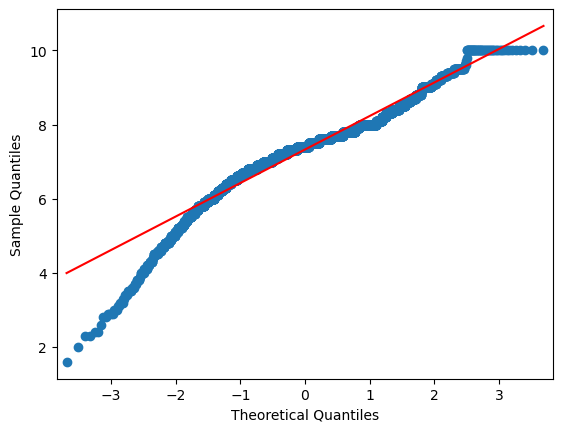

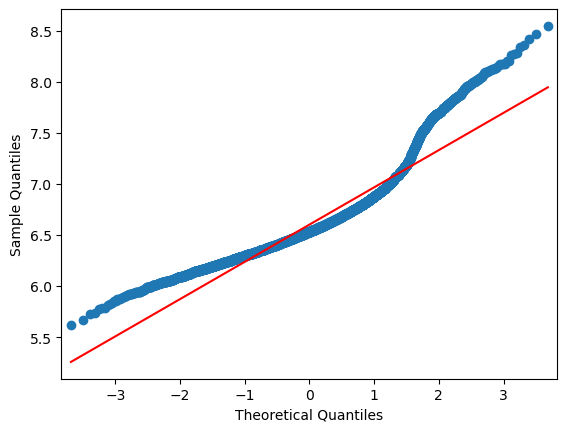

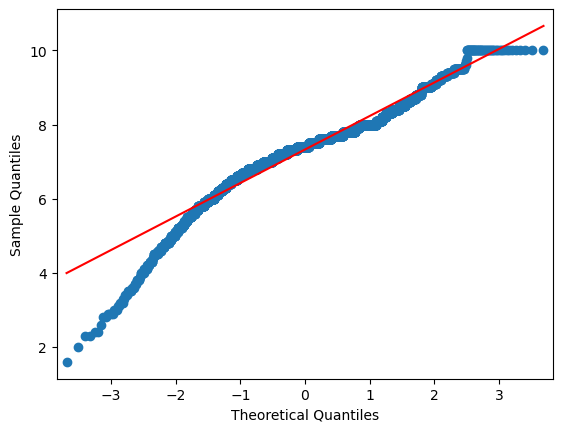

In [ ]:
sm.qqplot(df1['log_length'], line='s')
sm.qqplot(df1['score'], line='s')

In [99]:
df1['log_length'] = np.log(df1['length'])

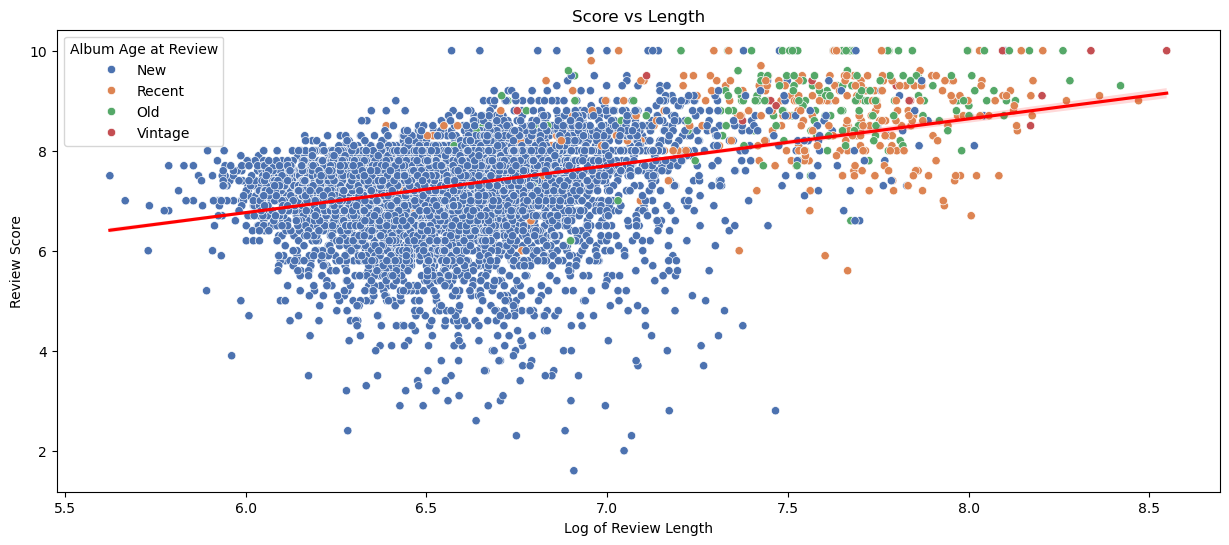

In [146]:
df1['age_category'] = pd.cut(df1['review_release_difference'], bins=4, labels=["New", "Recent", "Old", "Vintage"])

plt.figure(figsize=(15, 6))
sns.scatterplot(
    data=df1, 
    x="log_length", 
    y="score", 
    hue="age_category",
    palette="deep",
    #edgecolor="black"
)
sns.regplot(
    data=df1, 
    x="log_length", 
    y="score", 
    scatter=False, 
    color="red"
)
plt.title("Score vs Length")
plt.xlabel("Log of Review Length")
plt.ylabel("Review Score")
plt.legend(title="Album Age at Review")
if not os.path.exists("Visualizations/pitchfork_album_age.png"):
    plt.savefig("Visualizations/pitchfork_album_age.png")
plt.show()

In [ ]:
smf.ols('score ~ length + review_release_difference + followers_count + reviewer_reviews', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     514.3
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:42:02   Log-Likelihood:                -10652.
No. Observations:                8791   AIC:                         2.131e+04
Df Residuals:                    8786   BIC:                         2.135e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.7981      0.024    278.515      0.000       6.750       6.846
length                        0.0006   3.02e-05     20.811      0.000       0.001       0.001
review_release_difference     0.0193      0.002     12.516      0.000       0.016       0.022
followers_count           -1.035e-08   7.71e-10    -13.427      0.000   -1.19e-08   -8.84e-09
reviewer_reviews              0.0002   8.93e-05      2.016      0.044       5e-06       0.000
==============================================================================
Omnibus:                     2573.309   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9888.651
Skew:                          -1.418   Prob(JB):                         0.00
Kurtosis:                       7.353   Cond. No.                     3.31e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


20.697801689885868 [  0.         -13.45892683 -11.30776504 -13.65128692]


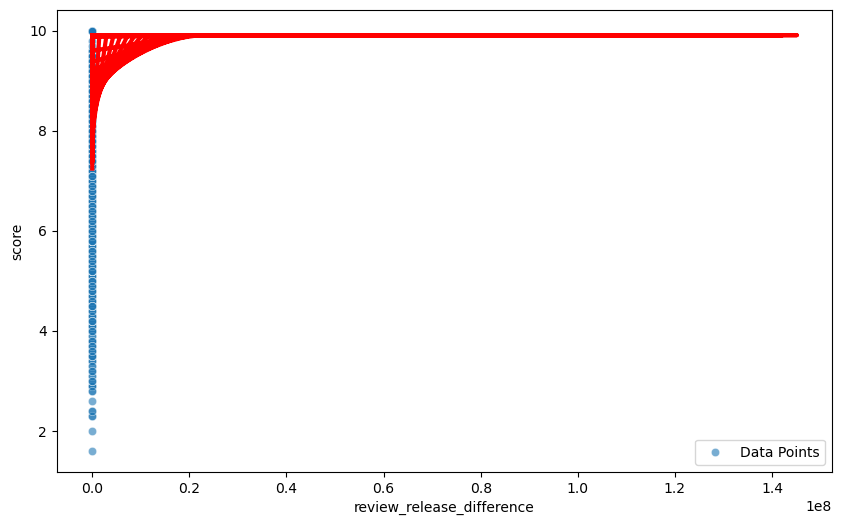

In [28]:
spline_transformer = SplineTransformer(
    degree=3, 
    n_knots=3, 
    knots='quantile',
    include_bias=False
)

X_spline = spline_transformer.fit_transform(df1[['review_release_difference']])

model = LinearRegression().fit(X_spline, y)

X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_plot_spline = spline_transformer.transform(X_plot)
y_pred = model.predict(X_plot_spline)
print(model.intercept_, model.coef_)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_release_difference', y='score', data=df1, alpha=0.6, label='Data Points')
plt.plot(X_plot, y_pred, color='red', linewidth=3, label='Cubic Spline Fit (SplineTransformer)')


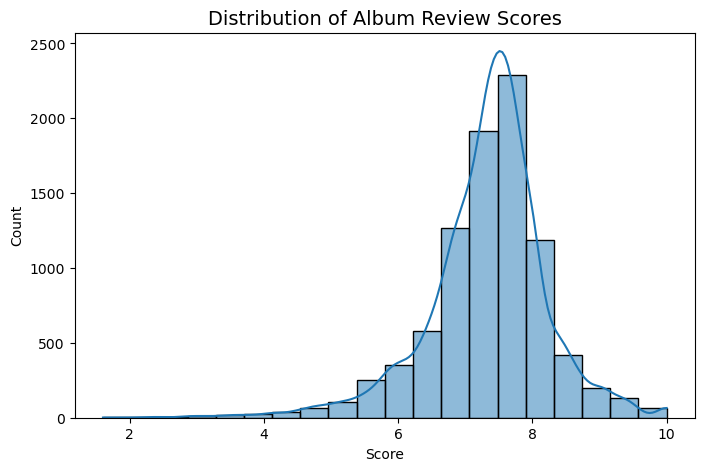

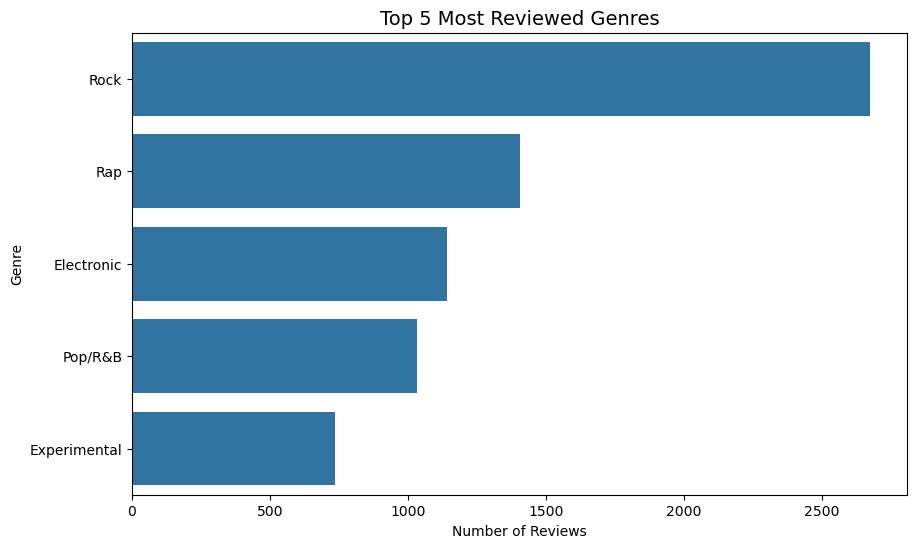

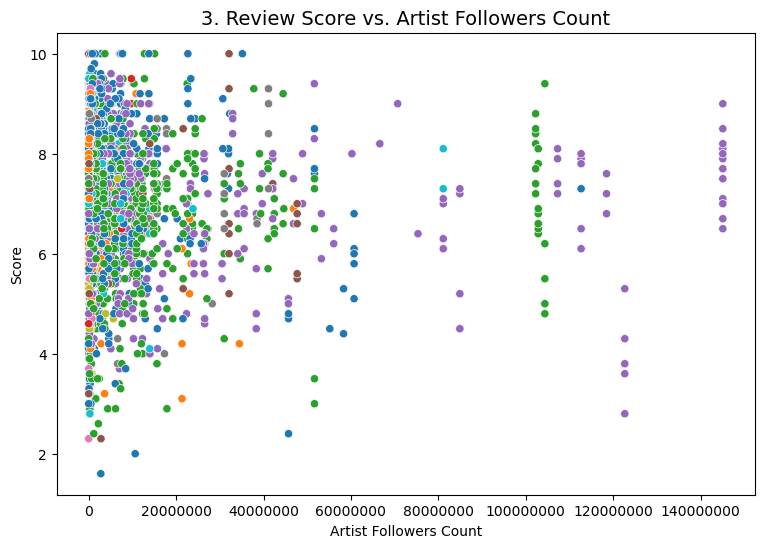

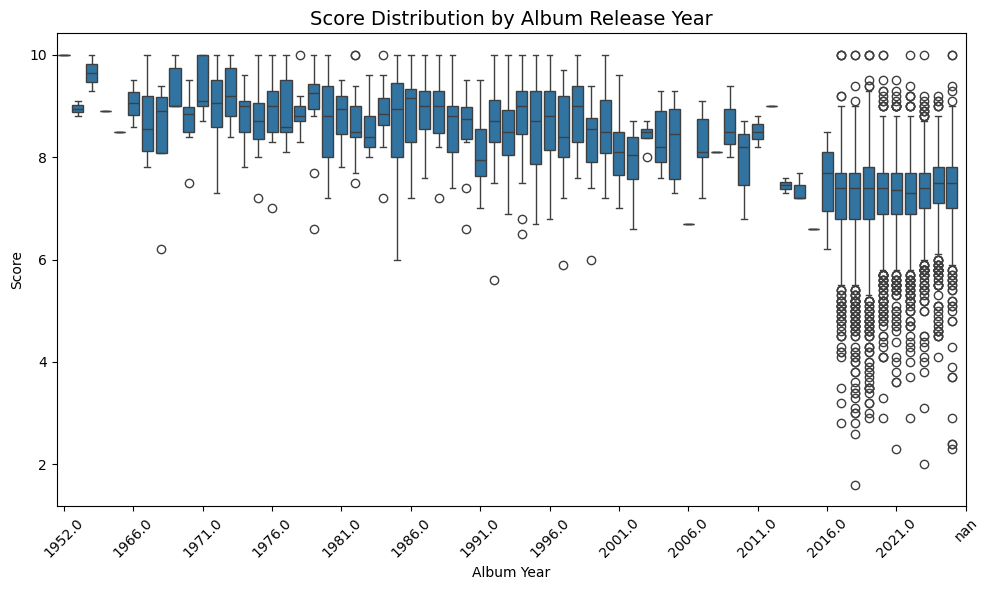

In [115]:
import os
# 1. Distribution of Review Scores
plt.figure(figsize=(8, 5))
sns.histplot(df['score'].dropna(), bins=20, kde=True, edgecolor='black')
plt.title('Distribution of Album Review Scores', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Count')
if not os.path.exists('Visualizations//pitchfork_score_distribution.png.png'):
    plt.savefig('Visualizations/pitchfork_score_distribution.png')
plt.show()


# 2. Countplot of Top 5 Genres
plt.figure(figsize=(10, 6))
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index[:5])
plt.title('Top 5 Most Reviewed Genres', fontsize=14)
plt.xlabel('Number of Reviews')
plt.ylabel('Genre')
if not os.path.exists('Visualizations/pitchfork_review_counts.png'):
    plt.savefig('Visualizations/pitchfork_review_counts.png')
plt.show()

# 3. Score vs. Artist Followers Count (for relationship checking)
plt.figure(figsize=(9, 6))
sns.scatterplot(x='followers_count', y='score', data=df, hue='genre', palette='tab10', legend=False)
plt.title('3. Review Score vs. Artist Followers Count', fontsize=14)
plt.xlabel('Artist Followers Count')
plt.ylabel('Score')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# 4. Album Year vs. Score (Time-based analysis)
plt.figure(figsize=(10, 6))
sns.boxplot(x='album_year', y='score', data=df.sort_values('album_year'))
# Show only a few ticks on the x-axis for readability
ticks = df['album_year'].unique()
ticks.sort()
plt.xticks(np.arange(len(ticks))[::5], ticks[::5], rotation=45)
plt.title('Score Distribution by Album Release Year', fontsize=14)
plt.xlabel('Album Year')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

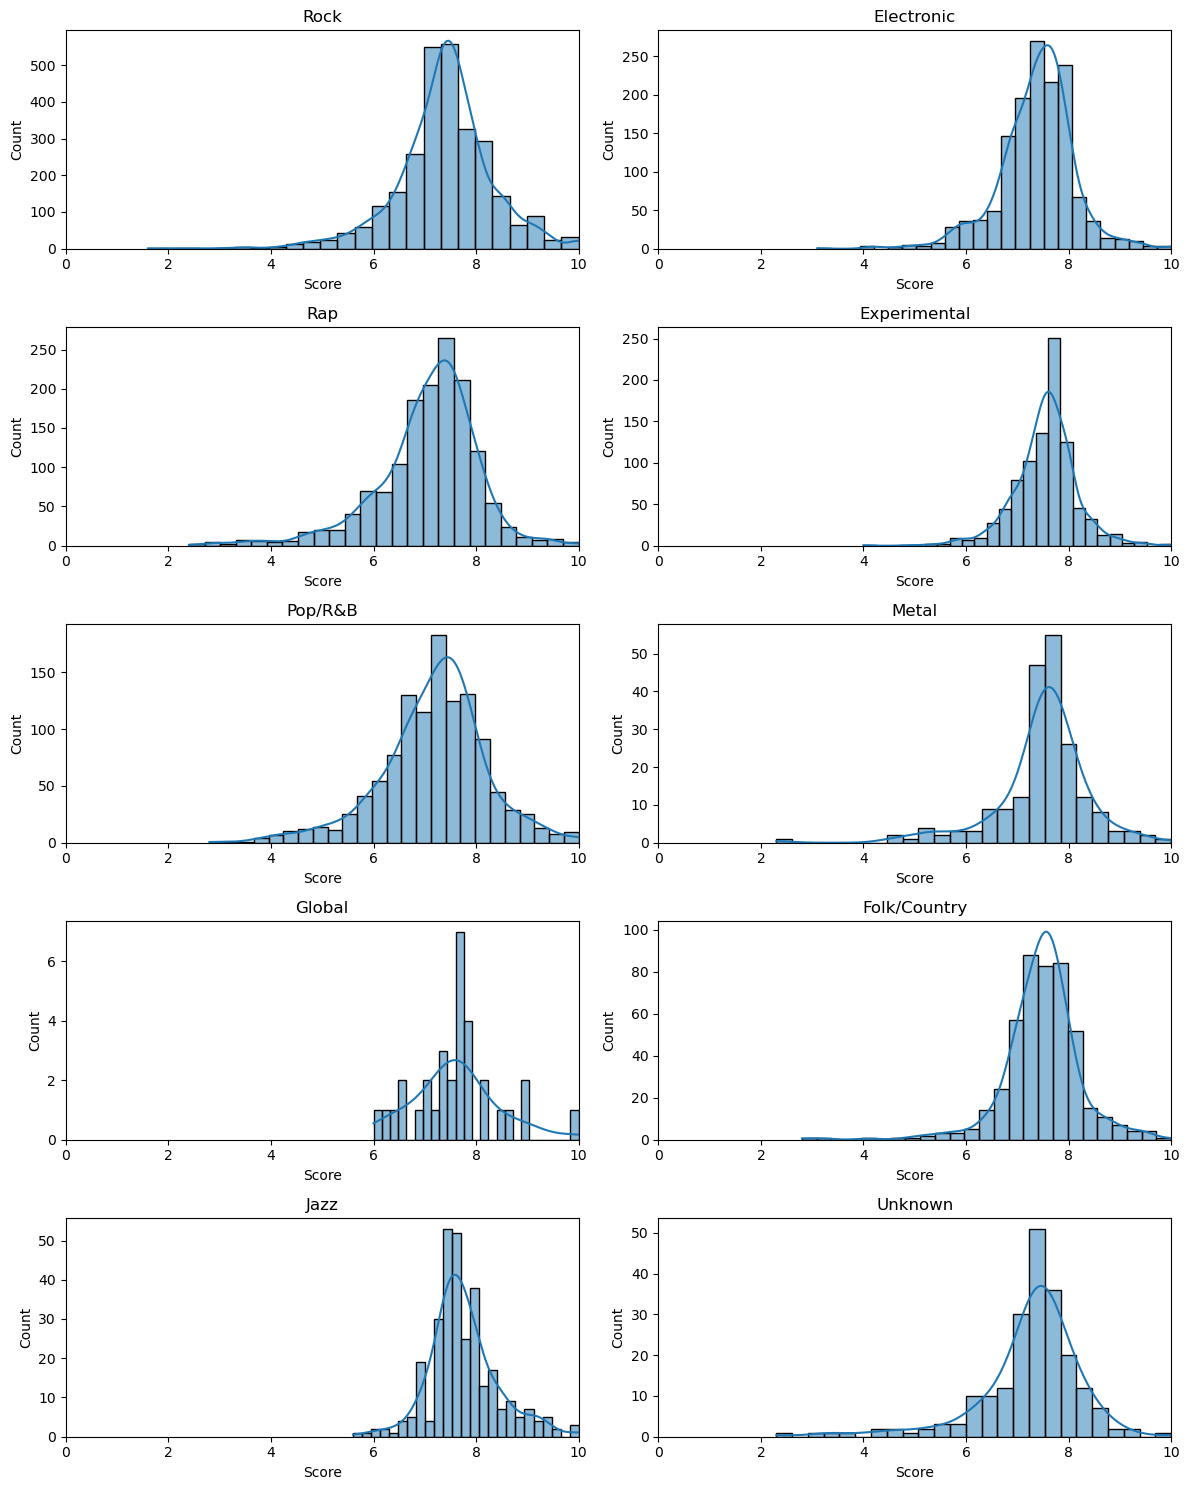

In [94]:
unique_genres = df['main_genre'].dropna().unique()
fig, axes = plt.subplots(5, 2, figsize=(12, 15)) 
axes = axes.flatten() 
for i, ax in enumerate(axes):
    if i < len(unique_genres):
        genre = unique_genres[i]
        subset = df[df['main_genre'] == genre]
        sns.histplot(subset['score'].dropna(), bins=25, kde=True, edgecolor='black', ax=ax)
        ax.set_title(f'{genre}', fontsize=12)
        ax.set_xlabel('Score')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 10)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
top_10_genres = df['main_genre'].value_counts().nlargest(100).index
df_filtered = df[df['main_genre'].isin(top_10_genres)].copy()
genre_scores = [
    df['score'][df['main_genre'] == g].dropna()
    for g in top_10_genres
]

f_statistic, p_value = f_oneway(*genre_scores)
print("\n--- Concise ANOVA Results (Top 10 Genres) ---")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4e}")

tukey_results = pairwise_tukeyhsd(
    endog=df_filtered['score'],       # The data (scores)
    groups=df_filtered['main_genre'],      # The groups (genres)
    alpha=0.05                        # Significance level
)
print(tukey_results)


--- Concise ANOVA Results (Top 10 Genres) ---
F-statistic: 38.4112
P-value: 1.1713e-67
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
  Electronic Experimental   0.1716 0.0003  0.0518  0.2914   True
  Electronic Folk/Country   0.1029 0.4847 -0.0479  0.2537  False
  Electronic       Global   0.2259   0.92 -0.2761  0.7278  False
  Electronic         Jazz   0.3845    0.0  0.2079  0.5611   True
  Electronic        Metal   0.1067 0.8485 -0.1043  0.3176  False
  Electronic      Pop/R&B  -0.2027    0.0 -0.3143  -0.091   True
  Electronic          Rap  -0.3235    0.0 -0.4285 -0.2184   True
  Electronic         Rock   0.0093    1.0  -0.083  0.1016  False
  Electronic      Unknown  -0.1294 0.6209 -0.3372  0.0785  False
Experimental Folk/Country  -0.0687 0.9403 -0.2291  0.0917  False
Experimental       Global   0.0542    1.0 -0.4507  0.5592  False
Ex

Classify into genres (Tukey HSD by score), maybe do KNN

In [37]:
df['review_year'] = df['review_year'].astype('category')

Mixed effects Model for Reviewers by adjusting y-int

In [38]:
smf.ols('score ~ length + review_release_difference + followers_count + reviewer_reviews + main_genre + review_year', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     119.3
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:51:48   Log-Likelihood:                -10472.
No. Observations:                8791   AIC:                         2.099e+04
Df Residuals:                    8769   BIC:                         2.114e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.8474      0.039    174.652      0.000       6.771       6.924
main_genre[T.Experimental]     0.1840      0.035      5.326      0.000       0.116       0.252
main_genre[T.Folk/Country]     0.0784      0.043      1.804      0.071      -0.007       0.164
main_genre[T.Global]           0.0586      0.145      0.403      0.687      -0.226       0.344
main_genre[T.Jazz]             0.2797      0.051      5.438      0.000       0.179       0.380
main_genre[T.Metal]            0.0821      0.061      1.352      0.176      -0.037       0.201
main_genre[T.Pop/R&B]         -0.2138      0.033     -6.406      0.000      -0.279      -0.148
main_genre[T.Rap]             -0.2984      0.031     -9.752      0.000      -0.358      -0.238
main_genre[T.Rock]            -0.0856      0.027     -3.174      0.002      -0.138      -0.033
main_genre[T.Unknown]         -0.2119      0.060     -3.543      0.000      -0.329      -0.095
review_year[T.2018]           -0.0540      0.034     -1.575      0.115      -0.121       0.013
review_year[T.2019]            0.0293      0.035      0.848      0.396      -0.038       0.097
review_year[T.2020]            0.0252      0.035      0.721      0.471      -0.043       0.094
review_year[T.2021]            0.0004      0.036      0.011      0.991      -0.070       0.071
review_year[T.2022]           -0.0100      0.035     -0.283      0.777      -0.080       0.059
review_year[T.2023]            0.0390      0.037      1.063      0.288      -0.033       0.111
review_year[T.2024]            0.1490      0.039      3.803      0.000       0.072       0.226
review_year[T.2025]            0.0451      0.041      1.088      0.277      -0.036       0.126
length                         0.0006   3.02e-05     21.333      0.000       0.001       0.001
review_release_difference      0.0183      0.002     11.976      0.000       0.015       0.021
followers_count            -8.043e-09    7.8e-10    -10.307      0.000   -9.57e-09   -6.51e-09
reviewer_reviews            8.382e-05   9.04e-05      0.927      0.354   -9.34e-05       0.000
==============================================================================
Omnibus:                     2477.319   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9593.078
Skew:                          -1.359   Prob(JB):                         0.00
Kurtosis:                       7.336   Cond. No.                     2.02e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+08. This might indicate that there are
strong multicollinearity or other numerical problems.


In [39]:
df['main_genre'].value_counts()

main_genre
Rock            2781
Rap             1471
Electronic      1387
Pop/R&B         1162
Experimental     909
Folk/Country     462
Jazz             309
Unknown          210
Metal            203
Global            32
Name: count, dtype: int64

## Predicting Genre

In [77]:
df.head()
df_filter = df.dropna(subset=['album_year', 'followers_count'])
df_filter = df_filter[df_filter['main_genre'] != 'Unknown']
print(df_filter.isna().sum())

url                           0
genre_cleaned                 0
genre_len                     0
main_genre                    0
artist                        0
album                         0
score                         0
genre                         0
label                        22
reviewer                      0
album_year                    0
review_date                   0
length                        0
artist_id                     0
followers_count               0
review_datetime               0
review_year                   0
reviewer_reviews              0
review_release_difference     0
artist_reviews                0
artist_review_number          0
matched                       0
dtype: int64


In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

numeric_features = ['score', 'album_year', 'length', 'followers_count', 
                    'reviewer_reviews', 'review_release_difference']
categorical_features = []
target = 'main_genre'

# 3. Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Split Data (80/20)
X = df_filter[numeric_features + categorical_features]
y = df_filter[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Build and Fit Model
model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

# 6. Predictions (Classes and Probabilities)
preds = model.predict(X_test)
probs = model.predict_proba(X_test)

# 7. Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))

print("\nAccuracy Score:")
print(accuracy_score(y_test, preds))

print("\nLog Loss:")
print(log_loss(y_test, probs))

Confusion Matrix:
[[ 49   1   0   0   0   0   0   2 209]
 [ 16   0   0   0   0   0   3   4 155]
 [  1   0   0   0   0   0   3   3  79]
 [  0   0   0   0   0   0   0   0   7]
 [  1   0   0   0   0   0   0   0  54]
 [  0   0   0   0   0   0   1   1  43]
 [  2   0   0   0   0   0  35  17 182]
 [  0   1   0   0   0   0  14  32 247]
 [  8   1   0   0   0   0   9  10 527]]

Accuracy Score:
0.37449039021549213

Log Loss:
1.7629117531516367


In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Define Features and Target
numeric_features = ['score', 'album_year', 'length', 'followers_count', 
                    'reviewer_reviews', 'artist_reviews']
categorical_features = ['label']
target = 'main_genre'

# 2. Minimal Preprocessing (Scaling + Encoding only)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Split Data
X = df_filter[numeric_features + categorical_features]
y = df_filter[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)

# 4. Build and Fit KNN Model
# n_neighbors=5 is the default
model = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=10))
model.fit(X_train, y_train)

# 5. Predictions
preds = model.predict(X_test)
probs = model.predict_proba(X_test)
loss = log_loss(y_test, probs, labels=model.classes_)

print(f"Log Loss: {loss:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))

print("\nAccuracy Score:")
print(accuracy_score(y_test, preds))

Log Loss: 5.3886
Confusion Matrix:
[[142  17   3   0   2   1  16  18  65]
 [ 64  31   3   0   2   1  12  14  53]
 [  7   5   7   0   0   0  12   5  49]
 [  3   0   0   0   0   0   1   0   4]
 [ 12   8   1   0  16   0   2   4  20]
 [  7   3   1   0   0   8   8   2  11]
 [ 35   8   4   0   3   0  96  23  65]
 [ 32   6   4   0   0   0  51 151  55]
 [ 43  28  13   0   1   3  46  56 354]]

Accuracy Score:
0.46884100174723353


In [80]:
np.unique(preds, return_counts=True)

(array(['Electronic', 'Experimental', 'Folk/Country', 'Jazz', 'Metal',
        'Pop/R&B', 'Rap', 'Rock'], dtype=object),
 array([336, 139,  47,  31,  11, 204, 248, 701]))